## Weather forecasting LSTM


In [1]:
!pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
# zip_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#     fname='jena_climate_2009_2016.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
df=pd.read_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data/Hvac_&_Energy_Combined.csv',index_col='time')

Let's take a glance at the data.

## The weather dataset


This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. 

In [124]:
df.head()

,Energy Meter Total Active Power,HVAC Compressor 1 Status,HVAC Compressor Status,HVAC Damper 1 Position,HVAC Delta_T,HVAC Fan 1 Fail,HVAC Free-Cool Status,HVAC Heater 1 Status,HVAC Heater Status,HVAC Indoor Temperature,HVAC Outdoor Temperature,HVAC Supply Air Temperature 1,HVAC Supply Fan 1 Speed,HVAC System Mode
time,,,,,,,,,,,,,,
2022-03-10 00:00:00,8.93,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,20.0,7.4,16.5,0.0,1.0
2022-03-10 00:01:00,8.71,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0,1.0
2022-03-10 00:02:00,8.92,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0,1.0
2022-03-10 00:03:00,8.98,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0,1.0
2022-03-10 00:04:00,9.27,0.0,0.0,0.0,12.6,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0,1.0


In [125]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [126]:
TRAIN_SPLIT = 111000

Setting seed to ensure reproducibility.

In [127]:
tf.random.set_seed(13)

In [128]:
uni_data = df['Energy Meter Total Active Power']
uni_data.head()

time
2022-03-10 00:00:00    8.93
2022-03-10 00:01:00    8.71
2022-03-10 00:02:00    8.92
2022-03-10 00:03:00    8.98
2022-03-10 00:04:00    9.27
Name: Energy Meter Total Active Power, dtype: float64

In [73]:
################################################################################
import matplotlib.pyplot as plt
%matplotlib inline
MEDIUM_SIZE = 10

plt.style.use(['seaborn'])
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 90  #default is 100

plt.rcParams['font.size']=MEDIUM_SIZE    
plt.rcParams['axes.titlesize']=MEDIUM_SIZE  
plt.rcParams['axes.labelsize']=MEDIUM_SIZE  
plt.rcParams['xtick.labelsize']=MEDIUM_SIZE        
plt.rcParams['ytick.labelsize']=MEDIUM_SIZE          
plt.rcParams['legend.fontsize']=MEDIUM_SIZE   
plt.rcParams['legend.labelcolor']='black'
plt.rcParams['figure.titlesize']=MEDIUM_SIZE        
################################################################################

array([<AxesSubplot:xlabel='time'>], dtype=object)

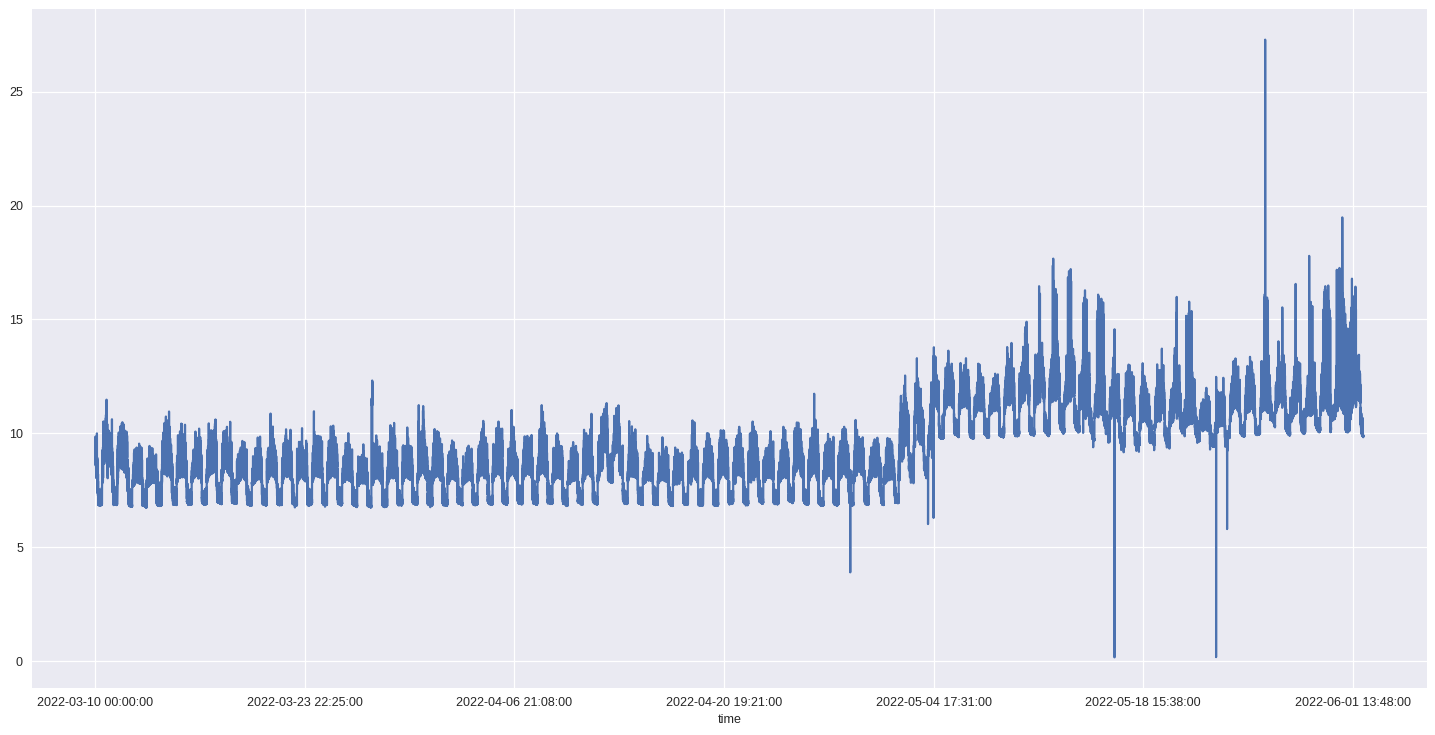

In [129]:
uni_data.plot(subplots=True)

In [130]:
uni_data = uni_data.values

In [131]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [132]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [133]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [79]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.01468921]
 [-0.12303275]
 [ 0.00842913]
 [ 0.04598966]
 [ 0.22753224]
 [ 0.32769367]
 [ 0.3089134 ]
 [ 0.07103002]
 [ 0.37151429]
 [ 0.27135287]
 [ 0.34021385]
 [ 0.32143358]
 [ 0.32143358]
 [ 0.37151429]
 [ 0.24631251]
 [ 0.27761296]
 [ 0.43411519]
 [ 0.23379233]
 [ 0.01468921]
 [ 0.13363091]]

 Target temperature to predict
-0.041651587618007226


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [134]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [135]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

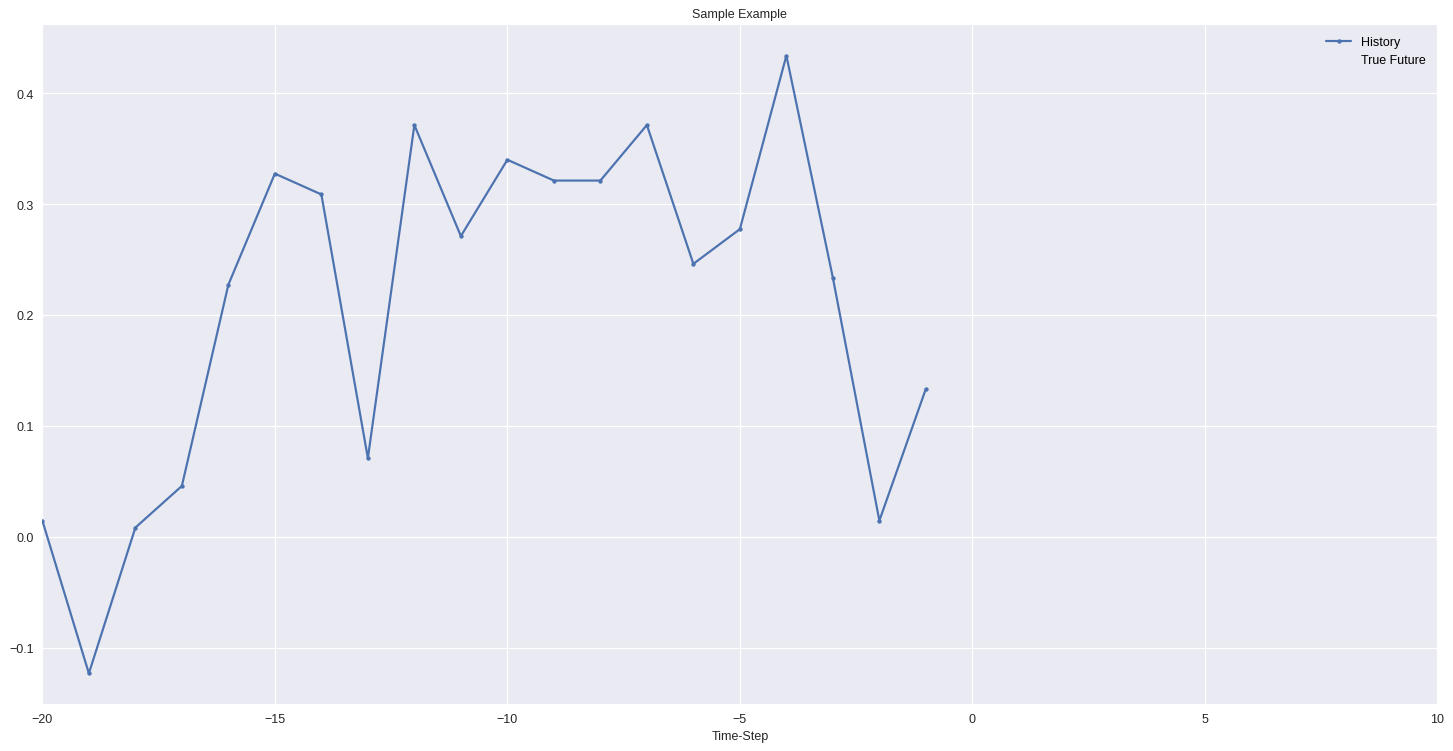

In [136]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [84]:
def baseline(history):
  return np.mean(history)

In [85]:
################################################################################
import matplotlib.pyplot as plt
%matplotlib inline
MEDIUM_SIZE = 8

plt.style.use(['seaborn'])
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 90  #default is 100

plt.rcParams['font.size']=MEDIUM_SIZE    
plt.rcParams['axes.titlesize']=MEDIUM_SIZE  
plt.rcParams['axes.labelsize']=MEDIUM_SIZE  
plt.rcParams['xtick.labelsize']=MEDIUM_SIZE        
plt.rcParams['ytick.labelsize']=MEDIUM_SIZE          
plt.rcParams['legend.fontsize']=MEDIUM_SIZE   
plt.rcParams['legend.labelcolor']='black'
plt.rcParams['figure.titlesize']=MEDIUM_SIZE        
################################################################################

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

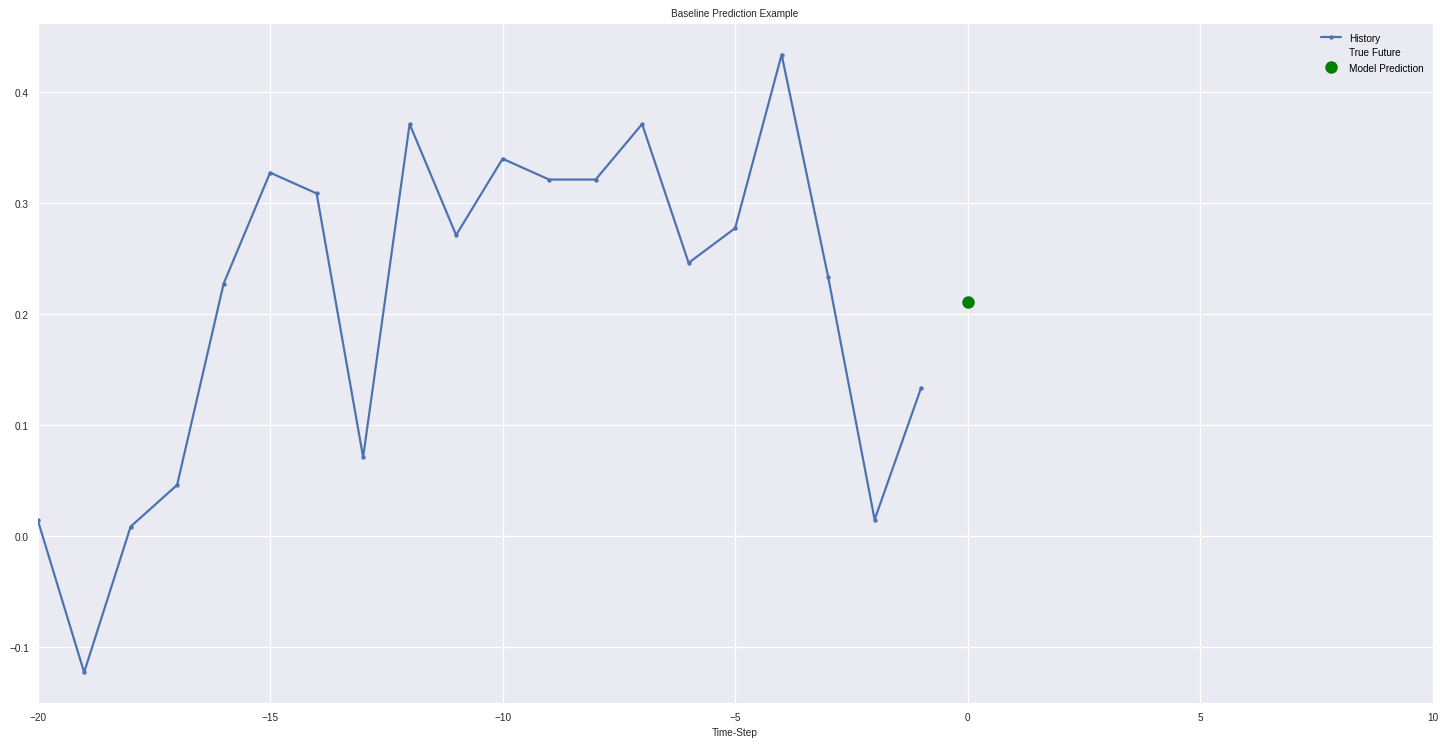

In [86]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [137]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [138]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [139]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [140]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/100
200/200 [==============================] - 3s 7ms/step - loss: 0.2173 - val_loss: 1.2410
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.2483 - val_loss: 0.2528
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 0.1311 - val_loss: 0.3386
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1334 - val_loss: 0.2356
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1279 - val_loss: 0.2757
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1214 - val_loss: 0.2321
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1362 - val_loss: 0.2517
Epoch 8/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1169 - val_loss: 0.2311
Epoch 9/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1380 - val_loss: 0.2253
Epoch 10/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1150 - val_lo

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

In [141]:
################################################################################
import matplotlib.pyplot as plt
%matplotlib inline
MEDIUM_SIZE = 7

plt.style.use(['seaborn'])
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 90  #default is 100

plt.rcParams['font.size']=MEDIUM_SIZE    
plt.rcParams['axes.titlesize']=MEDIUM_SIZE  
plt.rcParams['axes.labelsize']=MEDIUM_SIZE  
plt.rcParams['xtick.labelsize']=MEDIUM_SIZE        
plt.rcParams['ytick.labelsize']=MEDIUM_SIZE          
plt.rcParams['legend.fontsize']=MEDIUM_SIZE   
plt.rcParams['legend.labelcolor']='black'
plt.rcParams['figure.titlesize']=MEDIUM_SIZE        
################################################################################

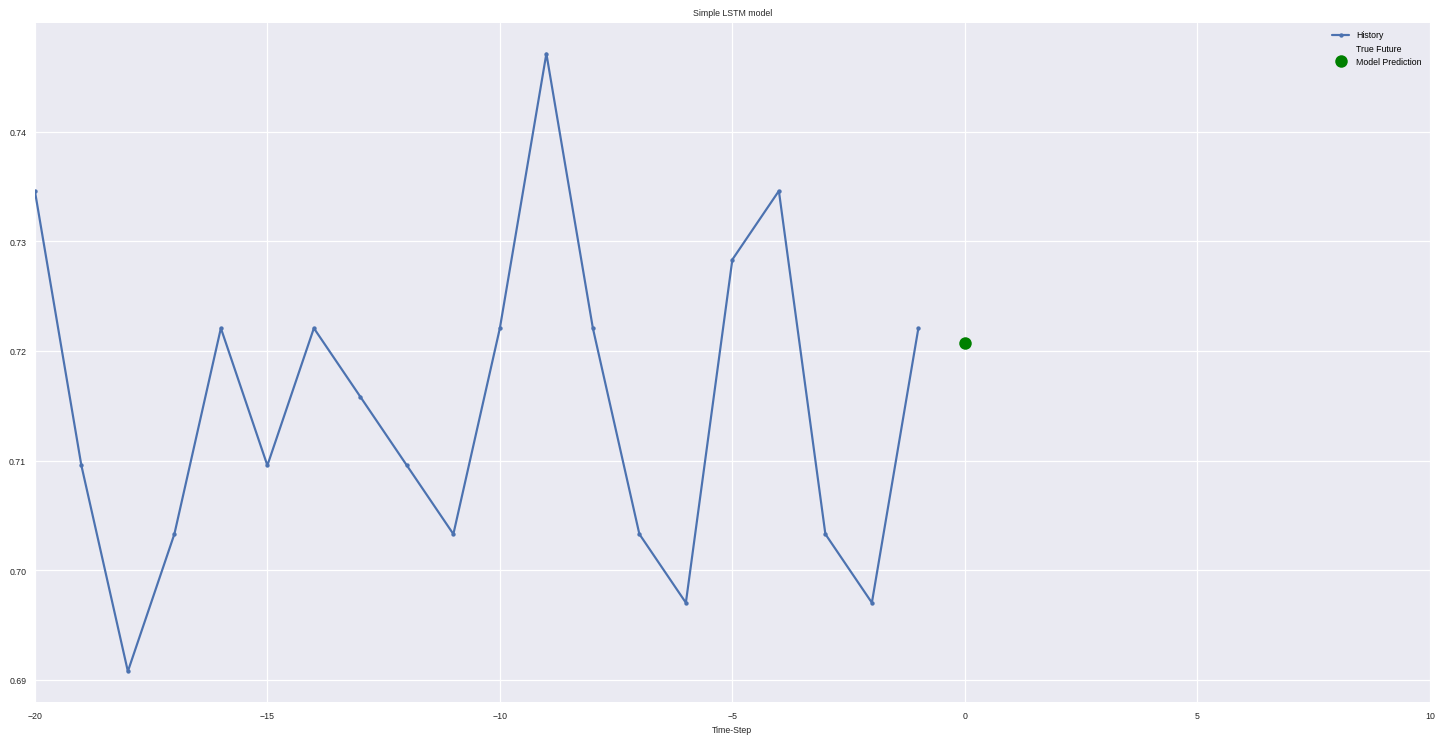

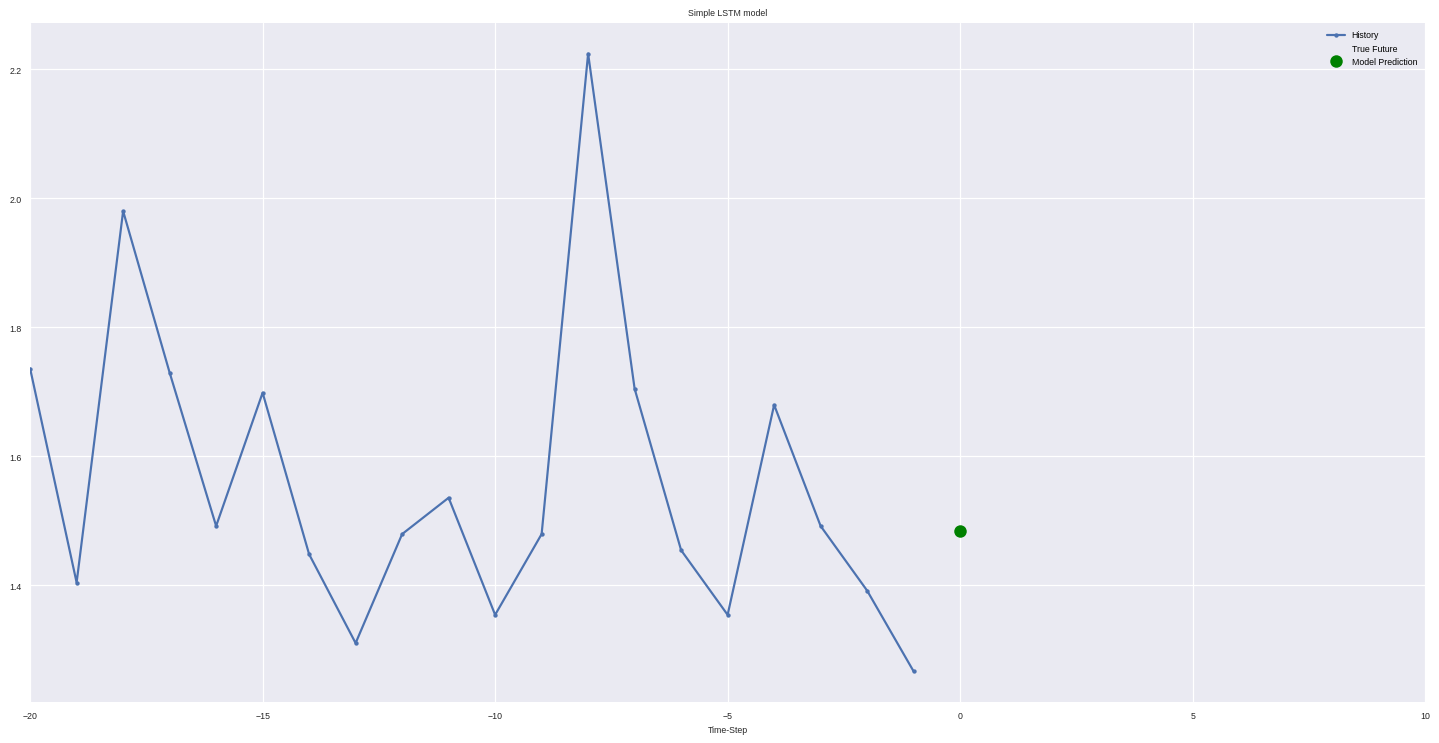

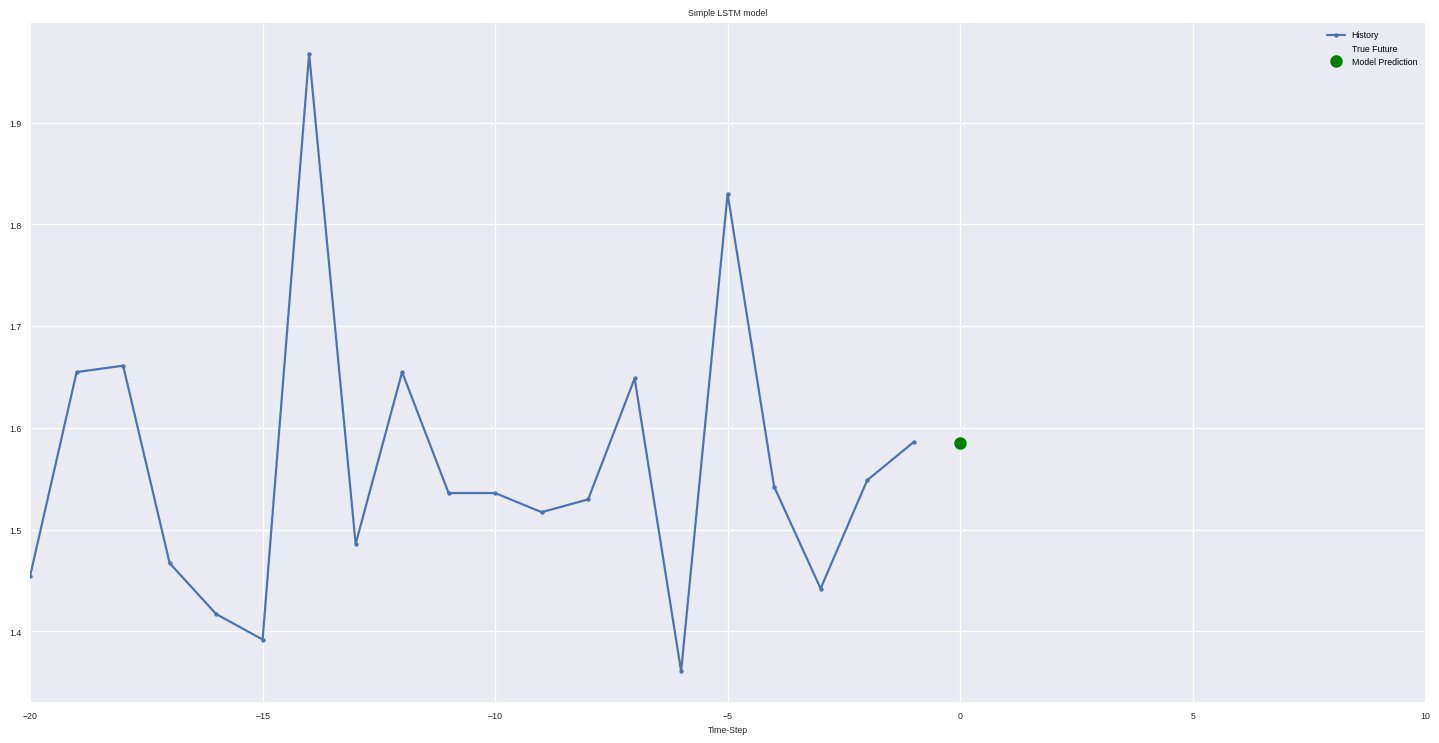

In [142]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [143]:
df.drop(columns=['HVAC Delta_T','HVAC Heater 1 Status','HVAC Heater Status','HVAC System Mode'],inplace=True,axis=1)
df

,Energy Meter Total Active Power,HVAC Compressor 1 Status,HVAC Compressor Status,HVAC Damper 1 Position,HVAC Fan 1 Fail,HVAC Free-Cool Status,HVAC Indoor Temperature,HVAC Outdoor Temperature,HVAC Supply Air Temperature 1,HVAC Supply Fan 1 Speed
time,,,,,,,,,,
2022-03-10 00:00:00,8.93,0.0,0.0,0.0,0.0,0.0,20.0,7.4,16.5,0.0
2022-03-10 00:01:00,8.71,0.0,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0
2022-03-10 00:02:00,8.92,0.0,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0
2022-03-10 00:03:00,8.98,0.0,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0
2022-03-10 00:04:00,9.27,0.0,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-06-02 06:39:00,9.88,0.0,0.0,100.0,0.0,10.0,22.4,15.9,18.3,28.0
2022-06-02 06:40:00,9.86,0.0,0.0,100.0,0.0,10.0,22.4,15.9,18.2,28.0
2022-06-02 06:41:00,9.87,0.0,0.0,100.0,0.0,10.0,22.4,15.9,18.1,28.0


In [144]:
df.columns

Index(['Energy Meter Total Active Power', 'HVAC Compressor 1 Status',
       'HVAC Compressor Status', 'HVAC Damper 1 Position', 'HVAC Fan 1 Fail',
       'HVAC Free-Cool Status', 'HVAC Indoor Temperature',
       'HVAC Outdoor Temperature', 'HVAC Supply Air Temperature 1',
       'HVAC Supply Fan 1 Speed'],
      dtype='object')

In [145]:
features_considered = ['Energy Meter Total Active Power', 'HVAC Compressor 1 Status',
       'HVAC Compressor Status', 'HVAC Damper 1 Position',
       'HVAC Free-Cool Status', 'HVAC Indoor Temperature',
       'HVAC Outdoor Temperature', 'HVAC Supply Air Temperature 1',
       'HVAC Supply Fan 1 Speed']

In [146]:
features = df[features_considered]
features.head()

,Energy Meter Total Active Power,HVAC Compressor 1 Status,HVAC Compressor Status,HVAC Damper 1 Position,HVAC Free-Cool Status,HVAC Indoor Temperature,HVAC Outdoor Temperature,HVAC Supply Air Temperature 1,HVAC Supply Fan 1 Speed
time,,,,,,,,,
2022-03-10 00:00:00,8.93,0.0,0.0,0.0,0.0,20.0,7.4,16.5,0.0
2022-03-10 00:01:00,8.71,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0
2022-03-10 00:02:00,8.92,0.0,0.0,0.0,0.0,19.9,7.4,16.5,0.0
2022-03-10 00:03:00,8.98,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0
2022-03-10 00:04:00,9.27,0.0,0.0,0.0,0.0,19.9,7.3,16.5,0.0


In [147]:
################################################################################
import matplotlib.pyplot as plt
%matplotlib inline
MEDIUM_SIZE = 10

plt.style.use(['seaborn'])
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 90  #default is 100

plt.rcParams['font.size']=MEDIUM_SIZE    
plt.rcParams['axes.titlesize']=MEDIUM_SIZE  
plt.rcParams['axes.labelsize']=MEDIUM_SIZE  
plt.rcParams['xtick.labelsize']=MEDIUM_SIZE        
plt.rcParams['ytick.labelsize']=MEDIUM_SIZE          
plt.rcParams['legend.fontsize']=MEDIUM_SIZE   
plt.rcParams['legend.labelcolor']='black'
plt.rcParams['figure.titlesize']=MEDIUM_SIZE        
################################################################################

Let's have a look at how each of these features vary across time.

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

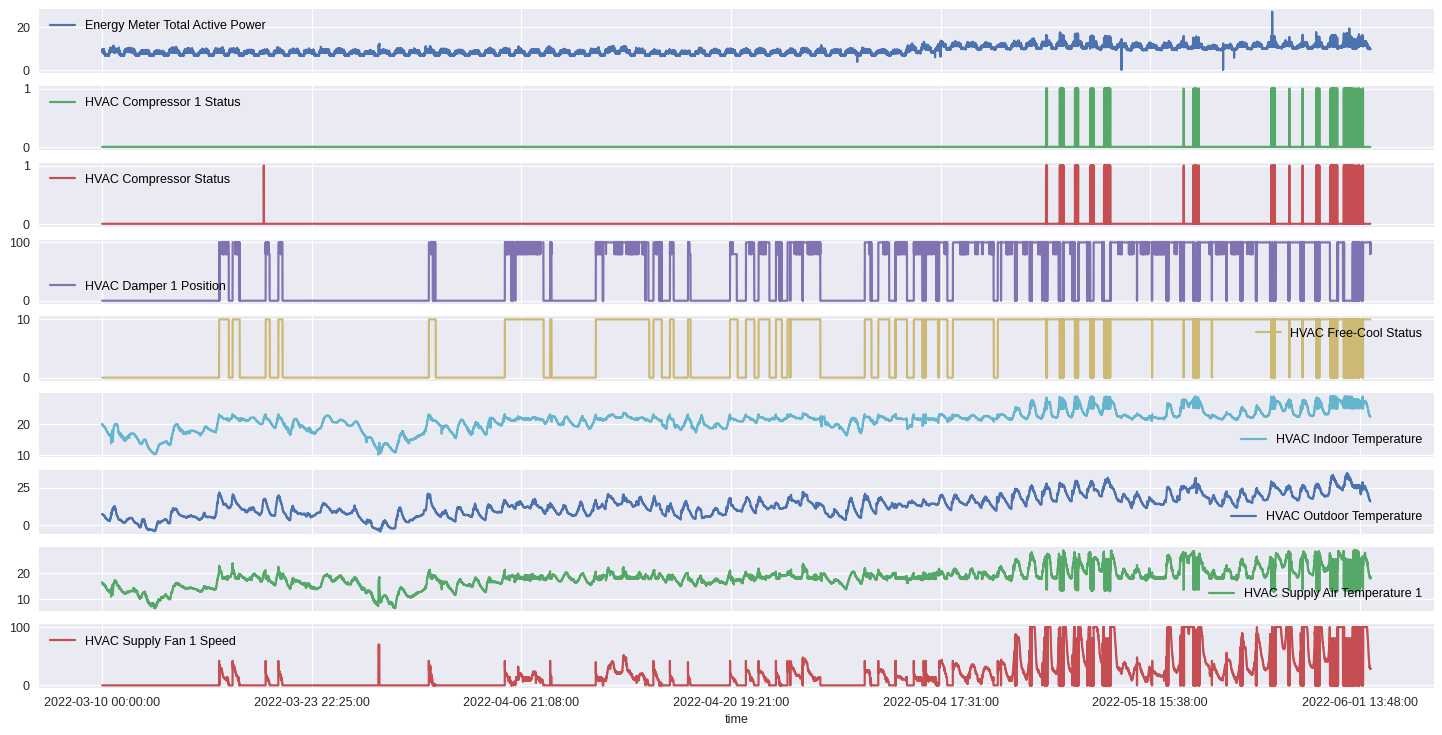

In [149]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [150]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [151]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [152]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [153]:
df.iloc[:,0]

time
2022-03-10 00:00:00    8.93
2022-03-10 00:01:00    8.71
2022-03-10 00:02:00    8.92
2022-03-10 00:03:00    8.98
2022-03-10 00:04:00    9.27
                       ... 
2022-06-02 06:39:00    9.88
2022-06-02 06:40:00    9.86
2022-06-02 06:41:00    9.87
2022-06-02 06:42:00    9.90
2022-06-02 06:43:00    9.89
Name: Energy Meter Total Active Power, Length: 121013, dtype: float64

In [154]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

The network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

Let's look at a single data-point.


In [155]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 9)


In [156]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [157]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [158]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [159]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/100
200/200 [==============================] - 4s 13ms/step - loss: 0.2552 - val_loss: 0.9826
Epoch 2/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2515 - val_loss: 0.3480
Epoch 3/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2217 - val_loss: 0.5493
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2197 - val_loss: 0.3592
Epoch 5/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2128 - val_loss: 0.4605
Epoch 6/100
200/200 [==============================] - 2s 12ms/step - loss: 0.2032 - val_loss: 0.3918
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2152 - val_loss: 0.4924
Epoch 8/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1877 - val_loss: 0.4775
Epoch 9/100
200/200 [==============================] - 2s 11ms/step - loss: 0.2206 - val_loss: 0.4267
Epoch 10/100
200/200 [==============================] - 2s 11ms/step - loss: 0.179

In [160]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

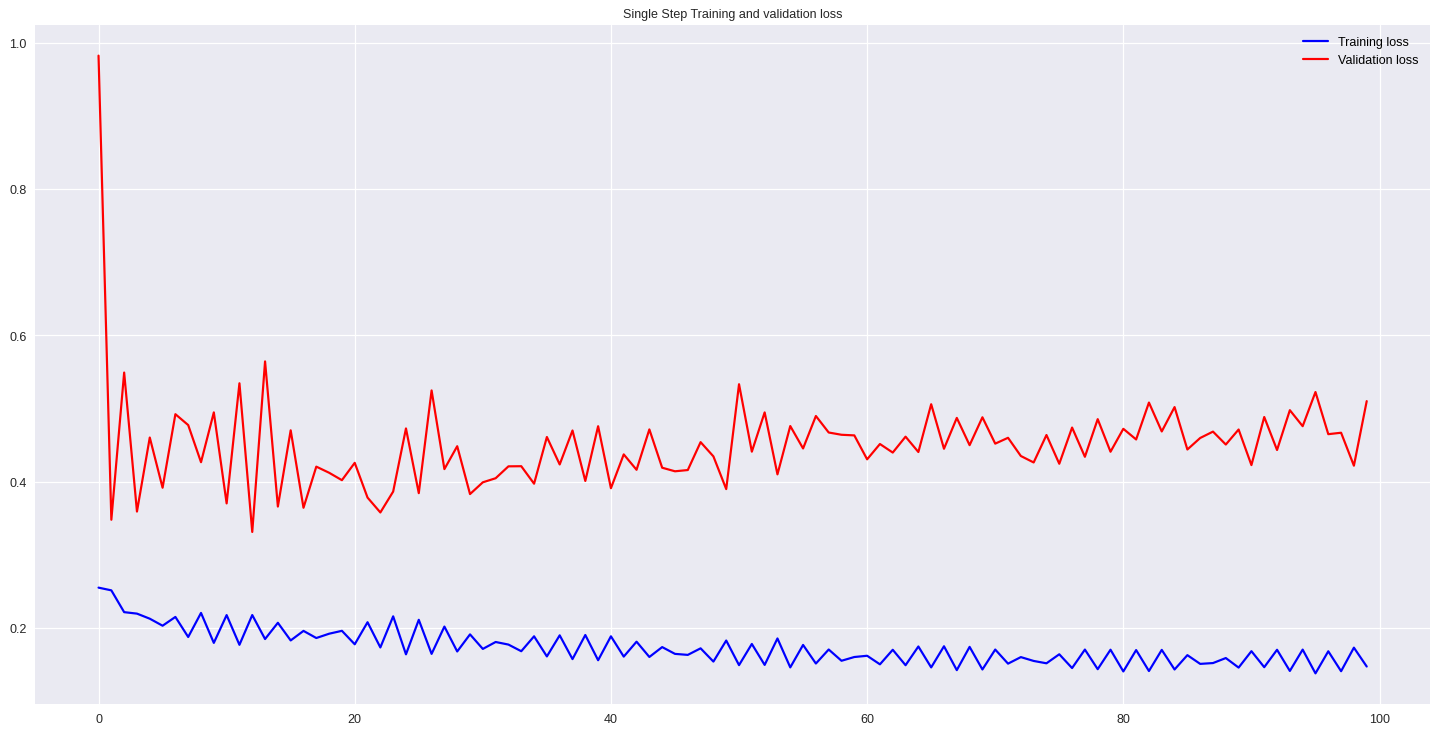

In [161]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

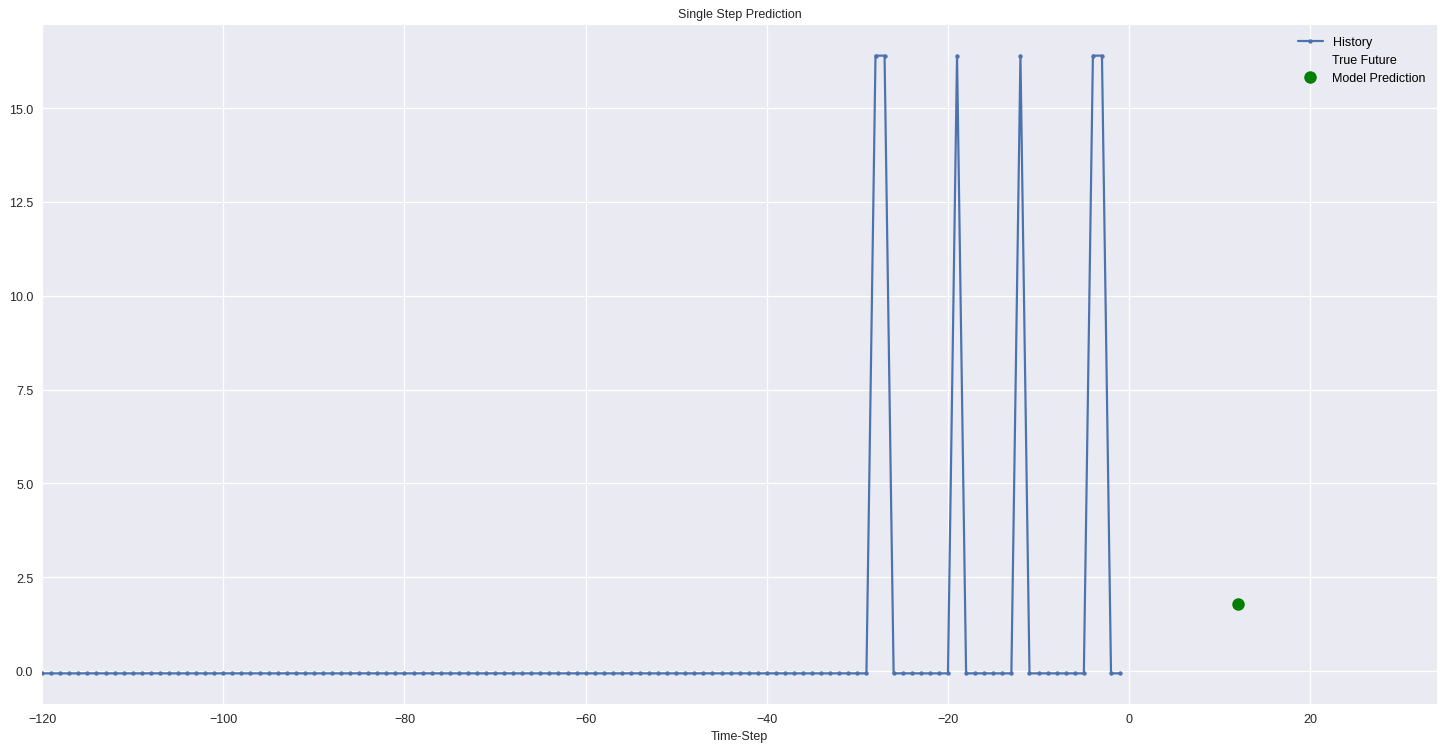

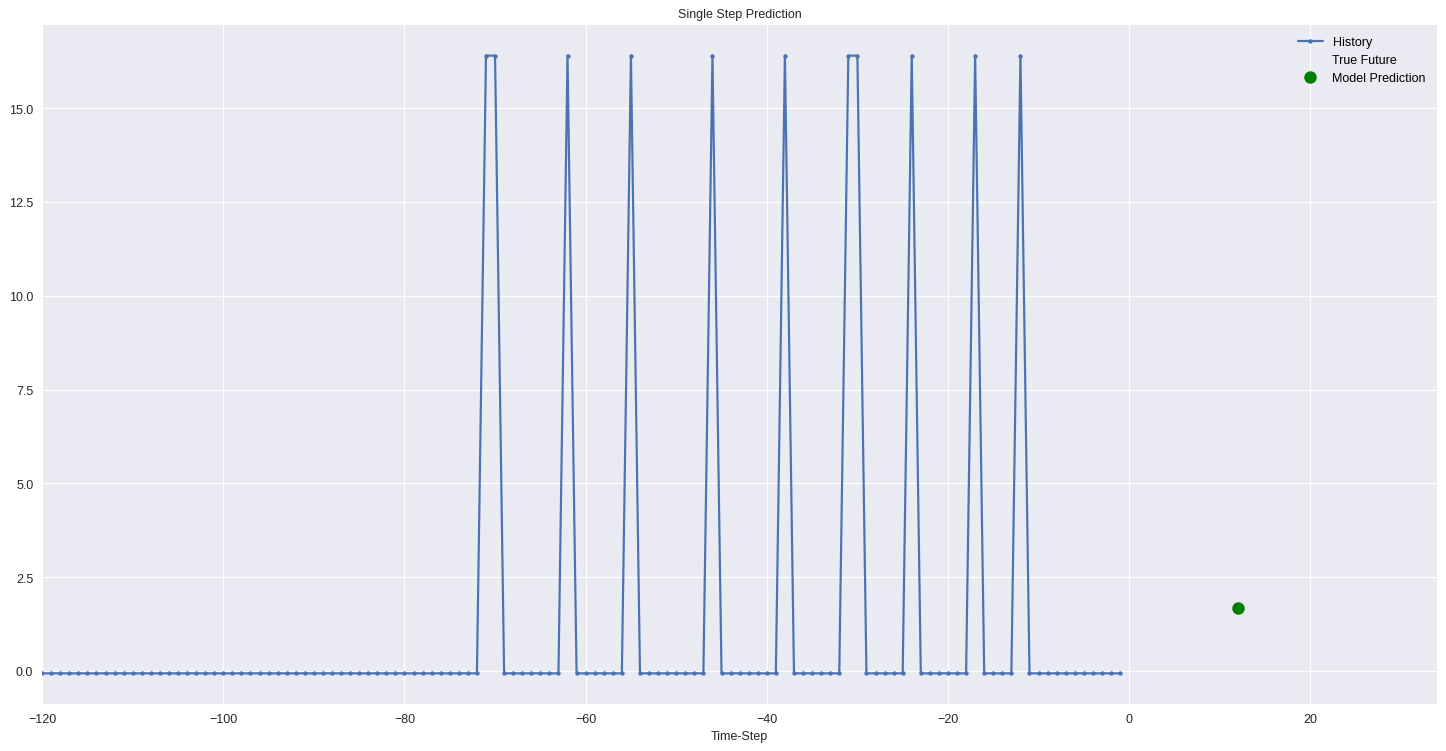

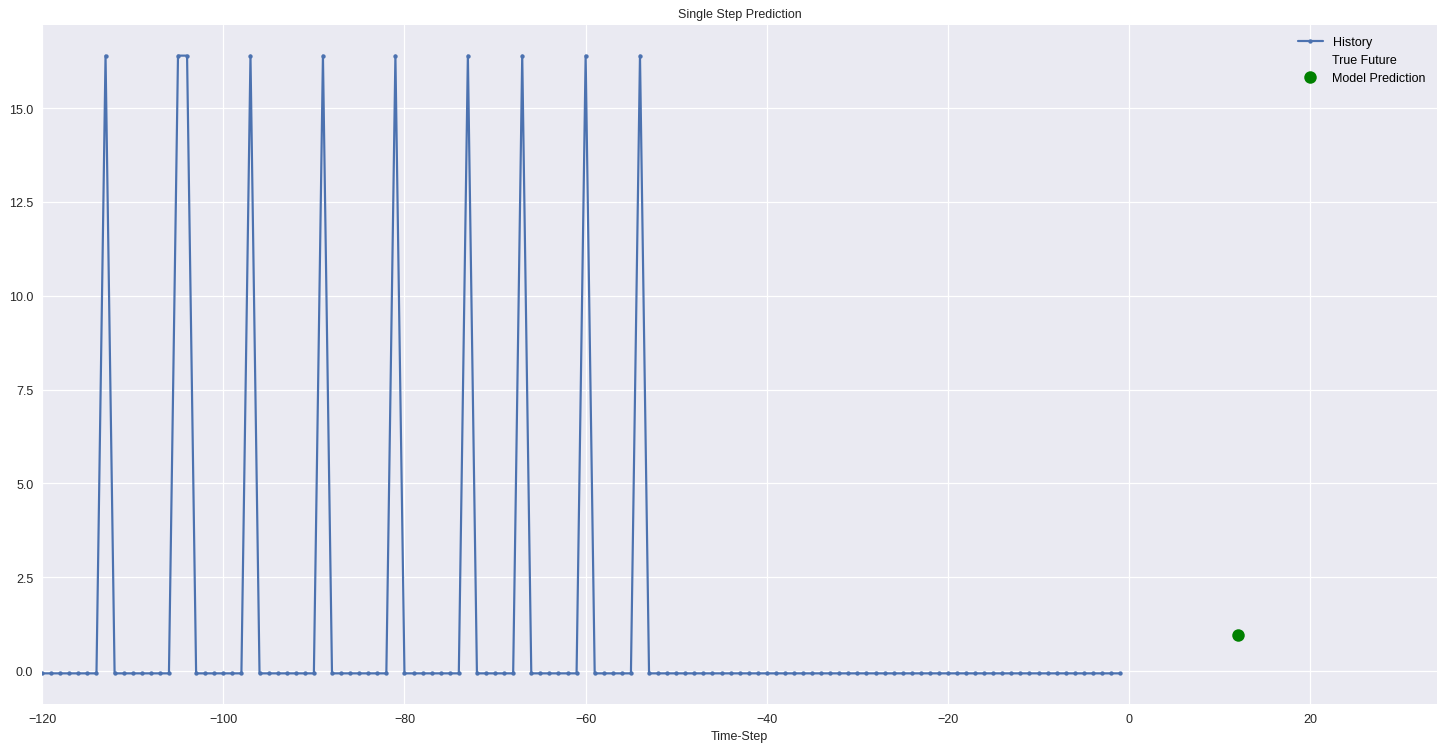

In [162]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [163]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [164]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 9)

 Target temperature to predict : (72,)


In [165]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [166]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

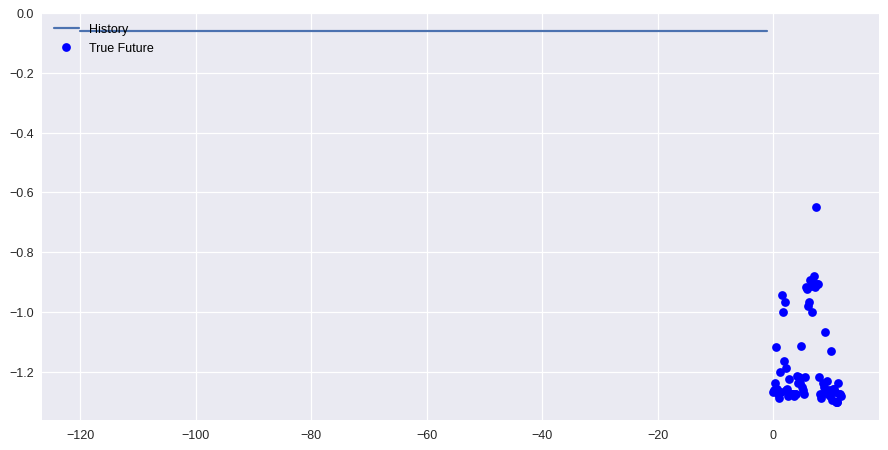

In [167]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [168]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [169]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [170]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/100
200/200 [==============================] - 42s 198ms/step - loss: 0.2862 - val_loss: 1.1916
Epoch 2/100
200/200 [==============================] - 39s 194ms/step - loss: 0.2816 - val_loss: 0.3479
Epoch 3/100
200/200 [==============================] - 39s 194ms/step - loss: 0.2081 - val_loss: 0.5461
Epoch 4/100
200/200 [==============================] - 39s 194ms/step - loss: 0.2094 - val_loss: 0.3062
Epoch 5/100
200/200 [==============================] - 39s 193ms/step - loss: 0.2012 - val_loss: 0.5811
Epoch 6/100
200/200 [==============================] - 39s 195ms/step - loss: 0.1906 - val_loss: 0.3279
Epoch 7/100
200/200 [==============================] - 39s 194ms/step - loss: 0.2040 - val_loss: 0.5512
Epoch 8/100
200/200 [==============================] - 39s 195ms/step - loss: 0.1764 - val_loss: 0.3305
Epoch 9/100
200/200 [==============================] - 39s 196ms/step - loss: 0.2055 - val_loss: 0.3268
Epoch 10/100
200/200 [==============================] - 39s 196m

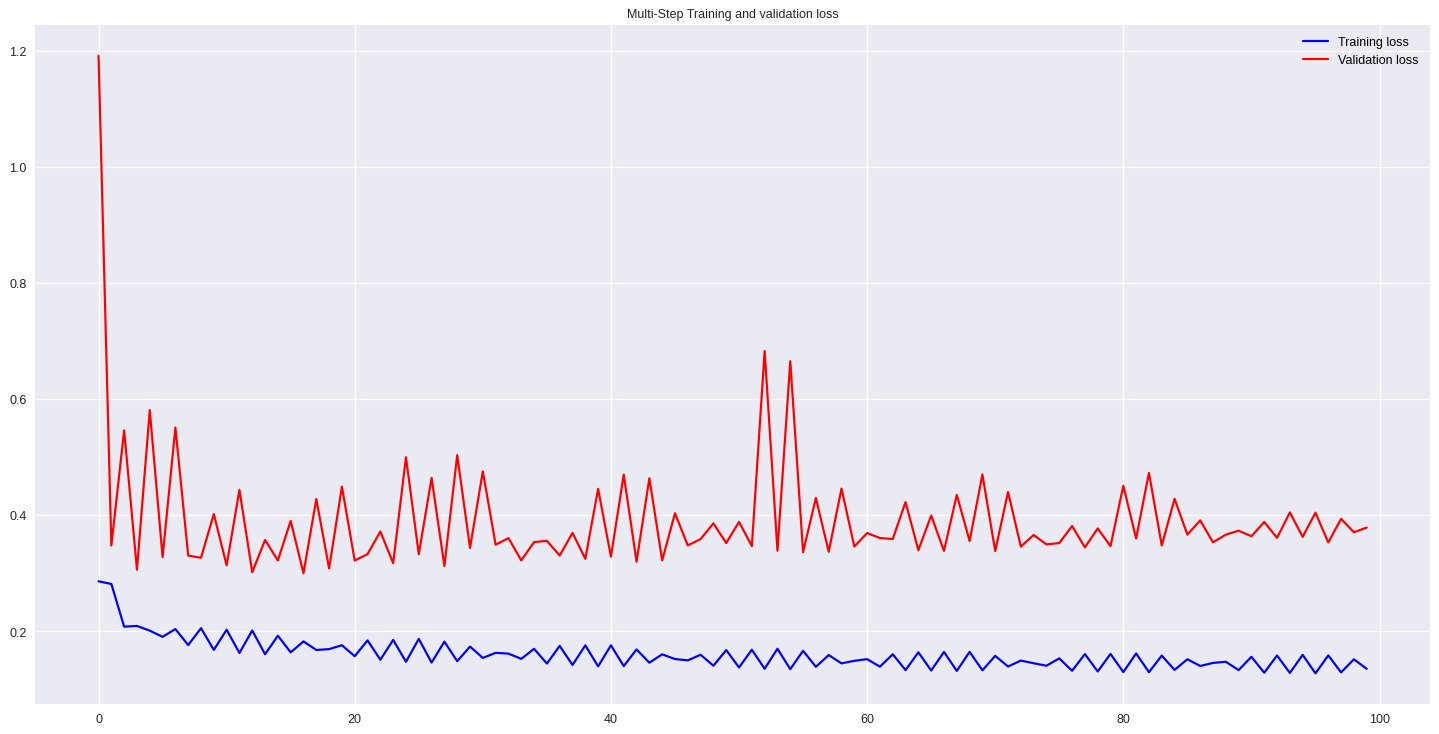

In [171]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

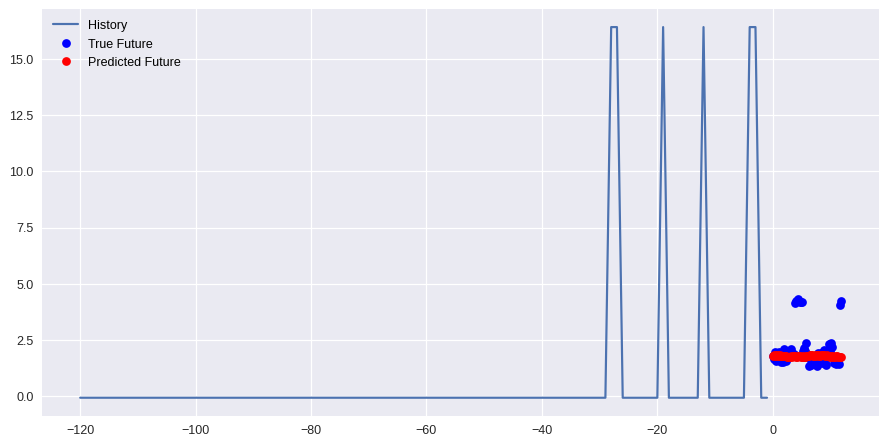

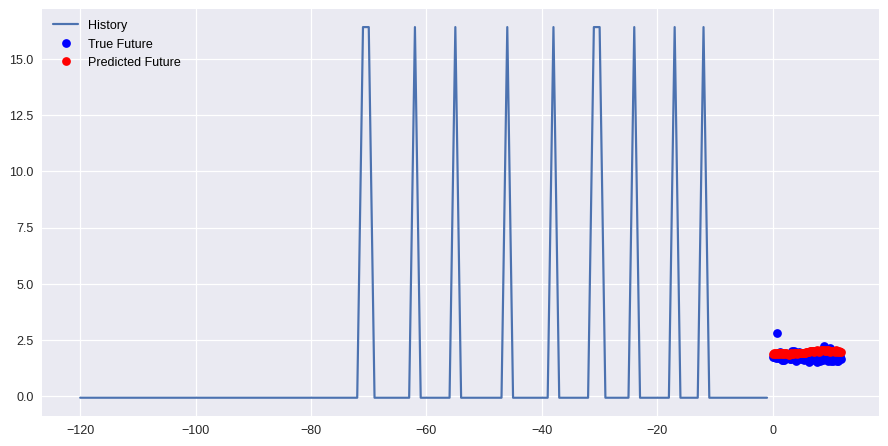

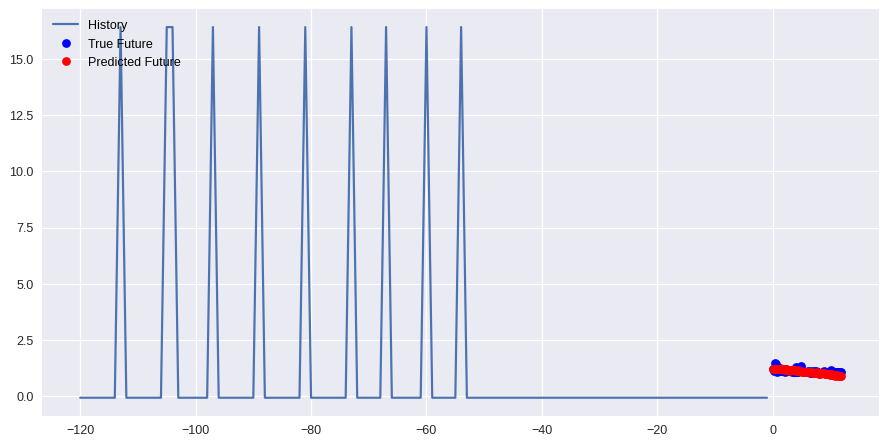

In [172]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])